## 6-8. 프로젝트 : 모든 장르 간 편향성 측정해 보기: TF-IDF 재사용으로 중복단어제거 버전 
지금까지 우리는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보았습니다. 어느 정도는 우리의 상식과 일치하는 편향성이 측정되었을 것입니다.

이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 보겠습니다. 대부분의 과정은 이전 스텝에서 이미 진행한 내용을 참고해서 동일하게 진행 가능할 것입니다.

#### 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


#### STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

**(1) 데이터 로드**

In [2]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

**(2) 형태소 분석 및  명사만 추출**

In [3]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [4]:
print(len(tokenized))
print(tokenized[:5])

71156
[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'], ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'], ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'], ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'], ['두', '사람', '날', '은수', '아파트', '밤']]


#### STEP 2. 추출된 결과로 embedding model 만들기

**(1) tokenized에 담긴 데이터로 word2vec embedding model 생성**


**[참고]**
* Word2Vec model은 문자 Sentence를 단어 토큰화해서, 정수 인덱싱없이 Sentence 상태로 입력함    
   - model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)     
* Word2Vec model은 보통은 별도로 train() 메소드없이 학습되는데, 학습하다중간에 저장했을 경우,다시 load하여,train시킬때, model.train(Sentence, total_examples=1, epochs=1)와 같이 학습시킴, 보통은 train 메소드없이 학습이 되는 것으로 보임

* pre_trained(사전학습)된 모델을 불러오려면, KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)으로 함




In [5]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8861260414123535),
 ('다큐멘터리', 0.8530097603797913),
 ('드라마', 0.7939074039459229),
 ('영화로', 0.7892283201217651),
 ('코미디', 0.7804297804832458),
 ('감동', 0.7655293345451355),
 ('주제', 0.7598181962966919),
 ('가족영화', 0.7541004419326782),
 ('실화', 0.7519022822380066),
 ('형식', 0.7507874369621277)]

In [6]:
#print(dir(model.wv))
#print(model.wv.vocab)
print(len(model.wv.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(model.wv['영화']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(model.wv.vectors.shape)

24320
100
(24320, 100)


In [7]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7100985050201416),
 ('우정', 0.7029013633728027),
 ('첫사랑', 0.7028791308403015),
 ('애정', 0.6936947703361511),
 ('이별', 0.6887538433074951),
 ('만남', 0.6867632865905762),
 ('진심', 0.6835126280784607),
 ('가슴', 0.6801111698150635),
 ('운명', 0.6779505014419556),
 ('마음', 0.669446587562561)]

In [8]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.8947084546089172),
 ('영화감독', 0.874247670173645),
 ('배우', 0.871331512928009),
 ('영감', 0.8710139989852905),
 ('연기', 0.8657849431037903),
 ('캐스팅', 0.8520033955574036),
 ('무용', 0.8489167094230652),
 ('대본', 0.8430731296539307),
 ('아티스트', 0.8416736721992493),
 ('예술', 0.8400095105171204)]

**(2) TF-IDF로 단어 셋만들기**

In [9]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [10]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [12]:
print(X[:,:5],X[0].shape)
print("dense",X[0].todense()[:5],len(X[0].todense()[0]))
print("tocco","col",X[0].tocoo().col,"data",X[0].tocoo().data, len(X[0].tocoo().col),len(X[0].tocoo().data))
#print("model.wv",[x for x in model.wv])
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

  (0, 1)	0.0003626867654624366
  (0, 3)	0.0003626867654624366
  (0, 4)	0.016683591211272084
  (1, 2)	5.3486686185153744e-05
  (1, 0)	0.001497627213184305
  (1, 1)	7.611243548713899e-05
  (1, 3)	0.00034250595969212547
  (1, 4)	0.019941458097630416 (1, 41082)
dense [[0.         0.00036269 0.         ... 0.         0.00025487 0.        ]] 1
tocco col [24288 30456 11824 ... 16979 23276 16393] data [0.00018134 0.00018134 0.00025487 ... 0.00398955 0.00072537 0.00253881] 18995 18995
23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)] # col: 단어인덱스  18955개, data: tfidf 값 18955개
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
print(len(w1), len(w2))

art_word100= []
gen_word100= []
print('예술영화를 대표하는 단어들:')
for i in range(100):
    artword = vectorizer.get_feature_names()[w1[i][0]]    
    print(artword, end=', ')
    art_word100.append(artword)
#print("art_word100", art_word100)       
print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    genword = vectorizer.get_feature_names()[w2[i][0]]    
    print(genword, end=', ')
    gen_word100.append(genword   )
#print("gen_word100", gen_word100) 


18995 37717
예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

**(3) 중복단어 제거후 대표성있는 단어 15개 선정**

* 1) 보존용: 15개

In [14]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 있는대로 모두 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): 
        target_art.append(w1_[i])
    
# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 1는대로 모두추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): 
        target_gen.append(w2_[i])
        
#중복 단어수 산정 
print(len(target_art), len(target_gen))  
same_word_num1 = 100 - len(target_art)
same_word_num2 = 100 - len(target_gen)
print("art, gen 양쪽 중복인 단어비율",(same_word_num1/100)*100 )

# w1,w2 둘다 15개씩 추출 
target_art =target_art[:15]
target_gen =target_gen[:15]
print("15개씩 추출:", len(target_art), len(target_gen))  



16 16
art, gen 양쪽 중복인 단어비율 84.0
15개씩 추출: 15 15


In [15]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [16]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


**(4) TF-IDF를 적용했을 때의 문제점 및 개선방안**

**[문제점]** 
* art, gen에서 중복비율이 84%인데, 남은 16개중 15개를 대표단어로 추출하면, 대표단어라고 해도 되는가 의문임,    
* 실제로  아래의 15개를 보면, art와 gen을 특징지우는 단어들이 별로 않보임    
* art와 gen 의 대표단어를 추출할수 있는 다른 방법도 색해 봐야 할듯   

**[개선책]**
* 중복 단어체크시 샘플을 현 100개에서 1000개로 늘려서 중복제거후 남은 개수가 150개이상일때 상위 15개를 추출해 보려함 

**(5) 개선방안으로 대표 단어 재추출**

In [17]:
n = 15
w1_, w2_ = [], []
for i in range(1000):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 있는대로 모두 추출한다.
target_art, target_gen = [], []
for i in range(1000):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): 
        target_art.append(w1_[i])
    
# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 1는대로 모두추출한다.
for i in range(1000):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): 
        target_gen.append(w2_[i])
        
#중복 단어수 산정 
print(len(target_art), len(target_gen))  
same_word_num1 = 1000 - len(target_art)
same_word_num2 = 1000 - len(target_gen)
print("art, gen 양쪽 중복인 단어비율",(same_word_num1/2000)*100 )  # 한개만 했으니,분모1000이라야함, 결과값인 단어비율에 곱하기2 필요

# w1,w2 둘다 15개씩 추출 
target_art =target_art[:15]
target_gen =target_gen[:15]
print("15개씩 추출:", len(target_art), len(target_gen))  

print("target_art", target_art)
print("target_gen", target_gen)

164 164
art, gen 양쪽 중복인 단어비율 41.8
15개씩 추출: 15 15
target_art ['북한', '황제', '레오', '아담', '진심', '무작정', '줄리', '뮤지션', '피아노', '외면', '선언', '메리', '카페', '단편영화', '뜻밖']
target_gen ['페스티벌', '다큐', '이미지', '정사', '아시아나', '인디애니페스트', '마사지', '비디오', '불륜', '최강', '에피소드', '개발', '상영', '애니', '출장']


**[재추출 결과 검토]**
* 15개씩 추출된 단어들을 보면, art 부분에 뮤지션, 피아노, 아담, 황제, 줄리등 예술적색채를 가진 단어들이 눈에 뜨이고,     
* gen도  '정사', '아시아나','마사지', '비디오', '불륜', '페스티벌' 등 일반 장르의 단어들이 눈에 뜨여, 대표성이 이전보다 훨씬 나아졌슴   
* 따라서, 이후 작업은 **중복제거후 상위 100개이상씩 추출**하고서,
* **100개중에서, 상위 15개씩 최종추출**해서, **대표단어로 사용**하도록 할예정임

**[다음step 부터 적용해볼 개선안]**    
**다음step에서는 attribute 영화장르별로 Tfidf한후 1000단어씩 추출하여,중복단어 제거위해 다시 Tfidf 하고서, 거기에서 대표단어 15개씩을 추출해서 ,WEAK score를 구해서, 검토해 보겠습니다. 

#### STEP 3. target, attribute 단어 셋 만들기
이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

**(1) 전체 장르별 대표 단어를 추출**

In [58]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [59]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [60]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


**Tfidf 후 장르별 21개장르 각각 1000단어씩 추출**

In [62]:
mall = [X[i].tocoo() for i in range(X.shape[0])]

wall = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in mall]

for i in range(len(wall)):
    wall[i].sort(key=lambda x: x[1], reverse=True)
    
print("장르별 단어개수", [len(x) for x in wall])

attributes = []
for i in range(len(wall)):
    print("i",i, genre_name[i], len(wall[i]))
    attr = []
       
    #j= 0
    
    for j in range(1000):
        if i== 12 and j > 450:
            continue
        #rint(i,j)
        if vectorizer.get_feature_names()[wall[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[wall[i][j][0]])
            #print(vectorizer.get_feature_names()[wall[i][j][0]]], end=', ')
        
    attributes.append(attr)
    
print("len(attributes)",len(attributes))

for i, attribu in enumerate(attributes):
    print("i",i, genre_name[i], end=': ')
    print(attribu[:10],len(attribu))
    

장르별 단어개수 [4698, 2470, 2229, 7761, 8036, 16162, 24040, 10744, 1397, 3745, 6004, 1416, 455, 5045, 6979, 12844, 12925, 3088, 2635, 13766, 3174]
i 0 SF 4698
i 1 가족 2470
i 2 공연 2229
i 3 공포(호러) 7761
i 4 기타 8036
i 5 다큐멘터리 16162
i 6 드라마 24040
i 7 멜로로맨스 10744
i 8 뮤지컬 1397
i 9 미스터리 3745
i 10 범죄 6004
i 11 사극 1416
i 12 서부극(웨스턴) 455
i 13 성인물(에로) 5045
i 14 스릴러 6979
i 15 애니메이션 12844
i 16 액션 12925
i 17 어드벤처 3088
i 18 전쟁 2635
i 19 코미디 13766
i 20 판타지 3174
len(attributes) 21
i 0 SF: ['위해', '자신', '지구', '시작', '사람', '인류', '인간', '미래', '우주', '그녀'] 963
i 1 가족: ['엄마', '아빠', '가족', '영화제', '자신', '위해', '친구', '아주르', '아버지', '시작'] 856
i 2 공연: ['오페라', '사랑', '토스카', '실황', '올레', '자신', '카바', '그녀', '공연', '오텔로'] 816
i 3 공포(호러): ['시작', '위해', '사람', '자신', '친구', '그녀', '사건', '공포', '발견', '죽음'] 1000
i 4 기타: ['영화제', '국제', '서울', '단편', '영화', '자신', '사람', '이야기', '그녀', '남자'] 1000
i 5 다큐멘터리: ['영화제', '영화', '다큐', '국제', '다큐멘터리', '사람', '이야기', '대한', '자신', '감독'] 1000
i 6 드라마: ['자신', '영화제', '그녀', '사람', '사랑', '영화', '위해', '시작', '국제', '남자'] 1000
i 

In [63]:
attributes_str = []
for i, attribu in enumerate(attributes):
    print("i",i, genre_name[i], end=': ')
    attribu_str = ' '.join(attribu)
    attributes_str.append(attribu_str)
print(attributes_str[0][:10],len(attributes_str))

i 0 SF: i 1 가족: i 2 공연: i 3 공포(호러): i 4 기타: i 5 다큐멘터리: i 6 드라마: i 7 멜로로맨스: i 8 뮤지컬: i 9 미스터리: i 10 범죄: i 11 사극: i 12 서부극(웨스턴): i 13 성인물(에로): i 14 스릴러: i 15 애니메이션: i 16 액션: i 17 어드벤처: i 18 전쟁: i 19 코미디: i 20 판타지: 위해 자신 지구 시 21


**중복을 제거하기위해서, Tfidf로 다시 재 벡터화** 

In [64]:
vectorizer_1 = TfidfVectorizer()
XX = vectorizer_1.fit_transform(attributes_str)

print(XX.shape)

(21, 7306)


**재Tfidf작업완료된 21개 장르별 벡터에서 상위 15개 대표단어추출** 

In [65]:
mall_1 = [XX[i].tocoo() for i in range(XX.shape[0])]

wall_1 = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in mall_1]

for i in range(len(wall_1)):
    wall_1[i].sort(key=lambda x: x[1], reverse=True)
    
print("장르별 단어개수", [len(x) for x in wall_1])

attributes_str15 = []
for i in range(len(wall_1)):
    print("i",i, genre_name[i], len(wall_1[i]))
    attr15 = []
      
    j = 0
    while (len(attr15) < 15):   # 장르별 15개씩 추출
        if vectorizer_1.get_feature_names()[wall_1[i][j][0]] in model.wv:
            attr15.append(vectorizer_1.get_feature_names()[wall_1[i][j][0]])
            print(vectorizer_1.get_feature_names()[wall_1[i][j][0]], end=', ')                    
        j += 1
   
    print("i len(attr15): ",i, len(attr15))  
    ## 최종 상위 15개짜리 append
    attributes_str15.append(attr15)
    print()

print("attributes_str15", len(attributes_str15), attributes_str15)    

장르별 단어개수 [963, 856, 816, 1000, 1000, 1000, 1000, 1000, 905, 972, 1000, 839, 438, 1000, 1000, 1000, 1000, 866, 855, 1000, 974]
i 0 SF 963
하락, 성민, 고갈, 가속, 자각, 아바, 수명, 엔터테인먼트, 플랫폼, 노화, 에덴, 강철, 제롬, 대치, 역대, i len(attr15):  0 15

i 1 가족 856
그림자극, 밤사이, 무상, 천호진, 석봉, 몬태나, 오물, 유방암, 분배, 나탄, 클라스, 인쇄, 리차, 꿈일, 종이컵, i len(attr15):  1 15

i 2 공연 816
콰이어트, 하이랜드, 레기나, 간인, 스트라빈스키, 통상, 망라, 디아나, 오페레타, 수전, 지휘봉, 편곡, 중창, 기마, 조카딸, i len(attr15):  2 15

i 3 공포(호러) 1000
화성, 알코올, 정비, 주차장, 유골, 선재, 숙주, 퇴마, 애나벨, 낭자, 앙리, 데릭, 고어, 분석, 외곽, i len(attr15):  3 15

i 4 기타 1000
비트, 기준, 조합, 청각, 중반, 계단, 달이, 선정, 연상, 장공, 시엠, 제렛, 이유나, 다애, 강남스타일, i len(attr15):  4 15

i 5 다큐멘터리 1000
시한, 제한, 미터, 영화계, 중요성, 연대기, 추모, 페루, 미학, 진보, 수족관, 제품, 소비, 남아공, 위원장, i len(attr15):  5 15

i 6 드라마 1000
샬롯, 성미, 베니스, 극적, 면회, 오지, 매료, 일자리, 전북, 기독교, 칸영화제, 문득, 제목, 미장센단편영화제, 피아니스트, i len(attr15):  6 15

i 7 멜로로맨스 1000
입사, 스물, 무료, 가정부, 혜경, 애교, 은정, 피오, 마나베, 니뇨, 철준, 덕훈, 도환, 아해, 선혜, i len(attr15):  7 15

i 8 뮤지컬 905
무수, 서기, 창작, 캐스팅, 외국, 맥주, 교외, 복장, 주로, 지연, 황량, 상

#### STEP 4. WEAT score 계산과 시각화
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

In [66]:
import numpy as np
from numpy import dot
from numpy.linalg import norm


In [67]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    print("c_a",c_a)
    print("c_b",c_b)
    mean_A = np.mean(c_a, axis=1) #-1)
    mean_B = np.mean(c_b, axis=1) #-1)
    print("mean_A", mean_A)
    print("mean_B", mean_B)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev



In [68]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print(len(matrix))

21


**전체 장르 WEAT score 계산**

In [70]:
# 전체 장르별 X,Y,A,B WEAT score
all_weat_score = []
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])
        all_weat_score.append([genre_name[i], genre_name[j],matrix[i][j]])
print("all_weat_score",len(all_weat_score))       

SF 가족 -0.6142598
SF 공연 -0.042399365
SF 공포(호러) -0.5521588
SF 기타 0.7329041
SF 다큐멘터리 0.5823552
SF 드라마 0.3740012
SF 멜로로맨스 -0.34746635
SF 뮤지컬 -0.036275502
SF 미스터리 -0.05352977
SF 범죄 -0.18071593
SF 사극 -0.6063424
SF 서부극(웨스턴) -0.51314795
SF 성인물(에로) -0.39280656
SF 스릴러 -0.29683405
SF 애니메이션 -0.82246804
SF 액션 -0.2921011
SF 어드벤처 -0.32851854
SF 전쟁 0.47412154
SF 코미디 -0.13245288
SF 판타지 -0.5524912
가족 공연 0.9053394
가족 공포(호러) -0.01824437
가족 기타 0.9962617
가족 다큐멘터리 0.6906596
가족 드라마 0.90826166
가족 멜로로맨스 -0.20747471
가족 뮤지컬 0.6446274
가족 미스터리 0.5595399
가족 범죄 0.42271286
가족 사극 -0.021364262
가족 서부극(웨스턴) -0.293417
가족 성인물(에로) -0.25607342
가족 스릴러 0.10613431
가족 애니메이션 -0.72669476
가족 액션 0.10751822
가족 어드벤처 0.6477782
가족 전쟁 0.7939682
가족 코미디 0.9209532
가족 판타지 -0.31023994
공연 공포(호러) -0.5276089
공연 기타 0.8705371
공연 다큐멘터리 0.57476866
공연 드라마 0.5703416
공연 멜로로맨스 -0.38849506
공연 뮤지컬 -0.010811316
공연 미스터리 -0.012513211
공연 범죄 -0.15424383
공연 사극 -0.7172473
공연 서부극(웨스턴) -0.49420148
공연 성인물(에로) -0.429549
공연 스릴러 -0.27559933
공연 애니메이션 -0.860155
공연 액션 -0.

In [71]:
# WEAT score가 0.8 이상, -0.8 이하의 경우만 추출
all_weat_score_sort = sorted(all_weat_score, key=lambda x: x[2], reverse= True)
all_weat_score_sort_core= all_weat_score_sort[:8] + all_weat_score_sort[-11:]
print(all_weat_score_sort_core)


[['가족', '기타', 0.9962617], ['애니메이션', '코미디', 0.95682347], ['가족', '코미디', 0.9209532], ['가족', '드라마', 0.90826166], ['가족', '공연', 0.9053394], ['공연', '기타', 0.8705371], ['애니메이션', '전쟁', 0.8544241], ['애니메이션', '어드벤처', 0.8339009], ['SF', '애니메이션', -0.82246804], ['범죄', '애니메이션', -0.84494454], ['기타', '어드벤처', -0.85817444], ['공연', '애니메이션', -0.860155], ['기타', '사극', -0.8662182], ['공포(호러)', '애니메이션', -0.8749958], ['미스터리', '애니메이션', -0.8999731], ['드라마', '애니메이션', -0.9042799], ['기타', '애니메이션', -0.96955174], ['기타', '뮤지컬', -1.0249937], ['기타', '드라마', -1.0777911]]


**[해석]**

WEAT score가 0.8 이상 8개, -0.8 이하의 11개 경우만 각각 공통적으로 해석해 보면 아래와 같습니다.

(1) 0.8 이상   
예술영화와 일반영화, 그리고 Attribute에 나와있는 21가지 장르중 대체로 가족영화와 애니메이션영화가 예술영화와 가깝고, 기타영화, 코미디, 전쟁, 어드벤쳐,등이 일반 영화와 가까운 것으로 Weat score 상 나타났습니다.
가족영화와 예술적인 영화의 대표단어들을 비교해 봐도 왜 그런지, 일반론적으로는 잘모르겠습니다. 

(2) -0.8이하   
예술영화와 일반영화, 그리고 Attribute에 나와있는 21가지 장르중 대체로 기타영화가 예술영화와 멀고, 애니메이션영화가 일반 영화와 압도적으로 먼 것으로 나타났습니다.
오히려 이 부분도 위의 것보다는 이해가가나, 뚜렷한 것 같지는 않습니다.

(3) 검토 결론       
중복단어를 제거하기 위해서, TFIDF를 반복사용해서, 중복단어를 제거하였는데도, 영화장르 카테고리의 대표단어들이 눈으로 개념적으로 보기에 그다지 가까워 보이지는 않았습니다.

영화 장르카테고리가 잘 분류되었나, 그리고 대표단어들이 그 장르와 잘맞는 것인지, 그리고, 근본적으로 자연어처리의 다른 부분에서는 유용하더라도,대표 단어들을 고르는 방법으로서의  TFIDF가 적합한 방법인지 의문이 드는데, 시간을 갖고서, 검토해 봐야 할 것 같습니다.


<AxesSubplot:>

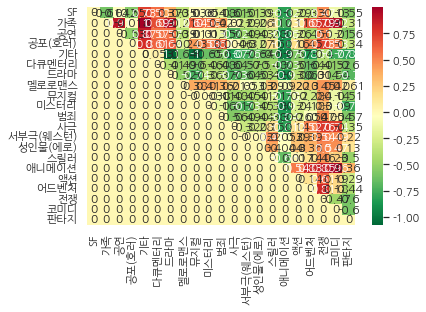

In [72]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

#### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준

1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.

워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다. 

2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.

타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.    

3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.

전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.